# CSE 676B
### Deep Learning
by `Prof. Alina Vereshchaka`
<br>

## <b>FINAL PROJECT</b>
<br>

<i>TEAM</i>🔻<br>
SOUBHIK SINHA (<b>soubhiks</b>)<br>
AISHWARYA MUTTINENI (<b>amuttine</b>)<br>
EKLAVYA (<b>eklavya</b>)
<br>
<br>

PROJECT TOPIC : <b><i>`BRAIN TUMOUR CLASSIFICATION USING DEEP LEARNING TECHNIQUES BASED ON MRI IMAGES`</i></b>

CHECKPOINT : <b><mark>April 4, 2024</mark></b><br>
FINAL SUBMISSION : <b><mark>May 2, 2024</mark></b>
<br><br>

COMPONENT : <b>`GoogLeNet`</b>

In [ ]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Let us import the necessary libraries required
# We will later on import more of them - as per requirement

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
'''
In the notebook for VGG13 implementation, we were already done with the
following :
- Data Extraction
- Data Reading
- Data Exploration
- Data Preprocessing
- Showing Main Statistics
- Splitting data into Train-Valid-Test sets
'''

# From here on we will only concentrate on the implementation of GoogLeNet

'\nIn the notebook for VGG13 implementation, we were already done with the\nfollowing :\n- Data Extraction\n- Data Reading\n- Data Exploration\n- Data Preprocessing\n- Showing Main Statistics\n- Splitting data into Train-Valid-Test sets\n'

### <b>STEP 1 : CREATION OF DATALOADERS</b>

In [ ]:
# Loading necessary libraries (both for model implementation
# and dataloader creation)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
# Setting device to GPU if available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
# Creating data loaders

import torch
from torchvision import transforms, datasets

# Defining a lower resolution
new_resolution = 224

# Defining transformations with lower resolution
transform = transforms.Compose([
    transforms.Resize((new_resolution, new_resolution)),  # Resizing images to new_resolution x new_resolution
    transforms.ToTensor(),          # Converting images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizing images
])

# Defining paths to the data
train_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Training'
val_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Validation'
test_data_path = '/content/drive/MyDrive/Datasets/Brain_tumour_Kaggle/Testing'

# Creating datasets with lower resolution
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
valid_dataset = datasets.ImageFolder(root=val_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

# Defining batch size
batch_size = 16

# Creating data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Lets have a look into the shape of the dataloaders

# Getting shape of train loader
for batch in train_loader:
    images, labels = batch
    print("Train Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

# Getting shape of validation loader
for batch in valid_loader:
    images, labels = batch
    print("Validation Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

# Getting shape of test loader
for batch in test_loader:
    images, labels = batch
    print("Test Loader Shape:", images.shape)
    break  # Printing only the shape of the first batch

Train Loader Shape: torch.Size([16, 3, 224, 224])
Validation Loader Shape: torch.Size([16, 3, 224, 224])
Test Loader Shape: torch.Size([16, 3, 224, 224])


<br>

### <b>STEP 2 : MODEL CREATION</b>

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)

class GoogLeNet(nn.Module):
    def __init__(self, dropout_prob=0.0):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_prob)  # Setting dropout probability
        self.linear = nn.Linear(1024, 4)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)  # Applying dropout
        out = self.linear(out)
        return out

In [ ]:
# Instantiating the model
GoogLeNet_model_base = GoogLeNet(dropout_prob=0.0).to(device)

In [ ]:
# Printing model summary
print(GoogLeNet_model_base)

GoogLeNet(
  (pre_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
   

<br>

### <b>STEP 3 : MODEL TRAINING AND VALIDATION</b>

In [ ]:
# Defining loss function and optimizer
criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(GoogLeNet_model_base.parameters(), lr=0.001)

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Training loop
num_epochs_base = 10
train_losses_base = []
train_accuracies_base = []
valid_losses_base = []
valid_accuracies_base = []

for epoch in range(num_epochs_base):
    # Training
    GoogLeNet_model_base.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_base.zero_grad()
        outputs = GoogLeNet_model_base(inputs)
        loss = criterion_base(outputs, labels)
        loss.backward()
        optimizer_base.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_base.append(epoch_train_loss)
    train_accuracies_base.append(epoch_train_accuracy)

    # Validation
    GoogLeNet_model_base.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = GoogLeNet_model_base(inputs)
            loss = criterion_base(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_base.append(epoch_valid_loss)
    valid_accuracies_base.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_base}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.8825, Train Acc: 0.6323, Valid Loss: 0.7293, Valid Acc: 0.7050
Epoch [2/10], Train Loss: 0.6813, Train Acc: 0.7319, Valid Loss: 0.6291, Valid Acc: 0.7275
Epoch [3/10], Train Loss: 0.6125, Train Acc: 0.7593, Valid Loss: 0.5127, Valid Acc: 0.8067
Epoch [4/10], Train Loss: 0.5349, Train Acc: 0.7942, Valid Loss: 2.0509, Valid Acc: 0.5108
Epoch [5/10], Train Loss: 0.4970, Train Acc: 0.8059, Valid Loss: 0.8578, Valid Acc: 0.7150
Epoch [6/10], Train Loss: 0.4603, Train Acc: 0.8267, Valid Loss: 0.5273, Valid Acc: 0.8025
Epoch [7/10], Train Loss: 0.4278, Train Acc: 0.8354, Valid Loss: 0.4624, Valid Acc: 0.8358
Epoch [8/10], Train Loss: 0.4068, Train Acc: 0.8486, Valid Loss: 0.5258, Valid Acc: 0.8225
Epoch [9/10], Train Loss: 0.3932, Train Acc: 0.8503, Valid Loss: 0.5170, Valid Acc: 0.8200
Epoch [10/10], Train Loss: 0.3458, Train Acc: 0.8706, Valid Loss: 0.4533, Valid Acc: 0.8358


<br>

### <b>STEP 4 : MODEL TESTING</b>

In [ ]:
# Testing the model

test_loss_base = 0.0
test_accuracy_base = 0.0
total_test_samples = 0
testing_predictions_base = []
true_labels_base = []

GoogLeNet_model_base.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = GoogLeNet_model_base(inputs)
        loss = criterion_base(outputs, labels)
        test_loss_base += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_base.extend(predicted.cpu().numpy())
        true_labels_base.extend(labels.cpu().numpy())

        test_accuracy_base += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_base /= len(test_loader)
test_accuracy_base /= len(test_loader)

print(f"Test Loss: {test_loss_base:.4f}, Test Accuracy: {test_accuracy_base:.4f}")

Test Loss: 0.5239, Test Accuracy: 0.8192


<br>

### <b>STEP 5 : Creating Various Setups</b>

In [ ]:
# Now let us create different setups to check
# which setup works the best, giving the best accuracy

'''
SETUP 1 : Adding Regularization (L2)
'''

GoogLeNet_model_1 = GoogLeNet().to(device)
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(GoogLeNet_model_1.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_1 = 10
train_losses_1 = []
train_accuracies_1 = []
valid_losses_1 = []
valid_accuracies_1 = []

for epoch in range(num_epochs_1):
    # Training
    GoogLeNet_model_1.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_1.zero_grad()
        outputs = GoogLeNet_model_1(inputs)
        loss = criterion_1(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_1.append(epoch_train_loss)
    train_accuracies_1.append(epoch_train_accuracy)

    # Validation
    GoogLeNet_model_1.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = GoogLeNet_model_1(inputs)
            loss = criterion_1(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_1.append(epoch_valid_loss)
    valid_accuracies_1.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_1}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.9278, Train Acc: 0.6187, Valid Loss: 1.0908, Valid Acc: 0.6108
Epoch [2/10], Train Loss: 0.5995, Train Acc: 0.7673, Valid Loss: 0.5436, Valid Acc: 0.8092
Epoch [3/10], Train Loss: 0.4762, Train Acc: 0.8132, Valid Loss: 0.4909, Valid Acc: 0.8125
Epoch [4/10], Train Loss: 0.3893, Train Acc: 0.8474, Valid Loss: 0.5045, Valid Acc: 0.8175
Epoch [5/10], Train Loss: 0.3070, Train Acc: 0.8865, Valid Loss: 0.5112, Valid Acc: 0.8100
Epoch [6/10], Train Loss: 0.2673, Train Acc: 0.9006, Valid Loss: 0.4064, Valid Acc: 0.8567
Epoch [7/10], Train Loss: 0.2299, Train Acc: 0.9136, Valid Loss: 0.6160, Valid Acc: 0.8050
Epoch [8/10], Train Loss: 0.1950, Train Acc: 0.9316, Valid Loss: 0.3768, Valid Acc: 0.8833
Epoch [9/10], Train Loss: 0.1537, Train Acc: 0.9458, Valid Loss: 0.5056, Valid Acc: 0.8567
Epoch [10/10], Train Loss: 0.1492, Train Acc: 0.9458, Valid Loss: 0.3676, Valid Acc: 0.8800


In [ ]:
# Testing the model

test_loss_1 = 0.0
test_accuracy_1 = 0.0
total_test_samples = 0
testing_predictions_1 = []
true_labels_1 = []

GoogLeNet_model_1.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = GoogLeNet_model_1(inputs)
        loss = criterion_1(outputs, labels)
        test_loss_1 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_1.extend(predicted.cpu().numpy())
        true_labels_1.extend(labels.cpu().numpy())

        test_accuracy_1 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_1 /= len(test_loader)
test_accuracy_1 /= len(test_loader)

print(f"Test Loss: {test_loss_1:.4f}, Test Accuracy: {test_accuracy_1:.4f}")

Test Loss: 0.4424, Test Accuracy: 0.8533


In [ ]:
'''
SETUP 2 : Regularization (L2) + Epochs (25) + Drop Out (0.1)
'''

GoogLeNet_model_2 = GoogLeNet(dropout_prob=0.1).to(device)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(GoogLeNet_model_2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_2 = 25
train_losses_2 = []
train_accuracies_2 = []
valid_losses_2 = []
valid_accuracies_2 = []

for epoch in range(num_epochs_2):
    # Training
    GoogLeNet_model_2.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_2.zero_grad()
        outputs = GoogLeNet_model_2(inputs)
        loss = criterion_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_2.append(epoch_train_loss)
    train_accuracies_2.append(epoch_train_accuracy)

    # Validation
    GoogLeNet_model_2.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = GoogLeNet_model_2(inputs)
            loss = criterion_2(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_2.append(epoch_valid_loss)
    valid_accuracies_2.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_2}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/25], Train Loss: 0.9101, Train Acc: 0.6106, Valid Loss: 0.7948, Valid Acc: 0.6975
Epoch [2/25], Train Loss: 0.5864, Train Acc: 0.7622, Valid Loss: 0.5093, Valid Acc: 0.8150
Epoch [3/25], Train Loss: 0.4849, Train Acc: 0.8137, Valid Loss: 0.5589, Valid Acc: 0.7975
Epoch [4/25], Train Loss: 0.3968, Train Acc: 0.8494, Valid Loss: 0.4627, Valid Acc: 0.8392
Epoch [5/25], Train Loss: 0.3375, Train Acc: 0.8694, Valid Loss: 0.5082, Valid Acc: 0.8217
Epoch [6/25], Train Loss: 0.2686, Train Acc: 0.8979, Valid Loss: 0.7148, Valid Acc: 0.7408
Epoch [7/25], Train Loss: 0.2276, Train Acc: 0.9167, Valid Loss: 0.4468, Valid Acc: 0.8442
Epoch [8/25], Train Loss: 0.1943, Train Acc: 0.9331, Valid Loss: 0.5435, Valid Acc: 0.8292
Epoch [9/25], Train Loss: 0.1809, Train Acc: 0.9387, Valid Loss: 0.6383, Valid Acc: 0.8117
Epoch [10/25], Train Loss: 0.1268, Train Acc: 0.9583, Valid Loss: 0.4270, Valid Acc: 0.8742
Epoch [11/25], Train Loss: 0.1303, Train Acc: 0.9536, Valid Loss: 0.6364, Valid Acc: 0.81

In [ ]:
# Testing the model

test_loss_2 = 0.0
test_accuracy_2 = 0.0
total_test_samples = 0
testing_predictions_2 = []
true_labels_2 = []

GoogLeNet_model_2.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = GoogLeNet_model_2(inputs)
        loss = criterion_2(outputs, labels)
        test_loss_2 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_2.extend(predicted.cpu().numpy())
        true_labels_2.extend(labels.cpu().numpy())

        test_accuracy_2 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_2 /= len(test_loader)
test_accuracy_2 /= len(test_loader)

print(f"Test Loss: {test_loss_2:.4f}, Test Accuracy: {test_accuracy_2:.4f}")

Test Loss: 0.4323, Test Accuracy: 0.8758


In [ ]:
'''
SETUP 3 :
- Regularization (L2)
- Epochs (50)
- Drop Out (0.1)
- Early Stopping
'''

GoogLeNet_model_3 = GoogLeNet(dropout_prob=0.1).to(device)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(GoogLeNet_model_3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_3 = 50
train_losses_3 = []
train_accuracies_3 = []
valid_losses_3 = []
valid_accuracies_3 = []

# Set up early stopping
best_valid_loss = np.inf
patience = 5  # Number of epochs to wait before early stopping

for epoch in range(num_epochs_3):
    # Training
    GoogLeNet_model_3.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_3.zero_grad()
        outputs = GoogLeNet_model_3(inputs)
        loss = criterion_3(outputs, labels)
        loss.backward()
        optimizer_3.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_3.append(epoch_train_loss)
    train_accuracies_3.append(epoch_train_accuracy)

    # Validation
    GoogLeNet_model_3.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = GoogLeNet_model_3(inputs)
            loss = criterion_3(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_3.append(epoch_valid_loss)
    valid_accuracies_3.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_3}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

    # Checking for early stopping
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        last_num_epochs_3 = epoch # Saving this for creating the graphs
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50], Train Loss: 0.9923, Train Acc: 0.6050, Valid Loss: 1.1630, Valid Acc: 0.5850
Epoch [2/50], Train Loss: 0.7206, Train Acc: 0.7258, Valid Loss: 0.6785, Valid Acc: 0.7325
Epoch [3/50], Train Loss: 0.5990, Train Acc: 0.7708, Valid Loss: 0.5509, Valid Acc: 0.8025
Epoch [4/50], Train Loss: 0.4795, Train Acc: 0.8176, Valid Loss: 0.6046, Valid Acc: 0.7733
Epoch [5/50], Train Loss: 0.4397, Train Acc: 0.8337, Valid Loss: 0.6492, Valid Acc: 0.7658
Epoch [6/50], Train Loss: 0.3846, Train Acc: 0.8499, Valid Loss: 0.6348, Valid Acc: 0.7800
Epoch [7/50], Train Loss: 0.3380, Train Acc: 0.8772, Valid Loss: 0.4522, Valid Acc: 0.8492
Epoch [8/50], Train Loss: 0.3251, Train Acc: 0.8831, Valid Loss: 0.3999, Valid Acc: 0.8475
Epoch [9/50], Train Loss: 0.2678, Train Acc: 0.8953, Valid Loss: 0.3955, Valid Acc: 0.8700
Epoch [10/50], Train Loss: 0.2446, Train Acc: 0.9092, Valid Loss: 0.4114, Valid Acc: 0.8617
Epoch [11/50], Train Loss: 0.1885, Train Acc: 0.9316, Valid Loss: 0.5011, Valid Acc: 0.86

In [ ]:
# Testing the model

test_loss_3 = 0.0
test_accuracy_3 = 0.0
total_test_samples = 0
testing_predictions_3 = []
true_labels_3 = []

GoogLeNet_model_3.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = GoogLeNet_model_3(inputs)
        loss = criterion_3(outputs, labels)
        test_loss_3 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_3.extend(predicted.cpu().numpy())
        true_labels_3.extend(labels.cpu().numpy())

        test_accuracy_3 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_3 /= len(test_loader)
test_accuracy_3 /= len(test_loader)

print(f"Test Loss: {test_loss_3:.4f}, Test Accuracy: {test_accuracy_3:.4f}")

Test Loss: 0.4126, Test Accuracy: 0.8817


In [ ]:
'''
SETUP 4 :
- Regularization (L2)
- Increased number of Epochs (25)
- Dropout (0.2)
- Different Learning rate (0.01)
'''

GoogLeNet_model_4 = GoogLeNet(dropout_prob=0.2).to(device)
criterion_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.SGD(GoogLeNet_model_4.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop
num_epochs_4 = 35
train_losses_4 = []
train_accuracies_4 = []
valid_losses_4 = []
valid_accuracies_4 = []

for epoch in range(num_epochs_4):
    # Training
    GoogLeNet_model_4.train()
    running_loss = 0.0
    total_train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_4.zero_grad()
        outputs = GoogLeNet_model_4(inputs)
        loss = criterion_4(outputs, labels)
        loss.backward()
        optimizer_4.step()
        running_loss += loss.item()
        total_train_accuracy += calculate_accuracy(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = total_train_accuracy / len(train_loader)
    train_losses_4.append(epoch_train_loss)
    train_accuracies_4.append(epoch_train_accuracy)

    # Validation
    GoogLeNet_model_4.eval()
    running_loss = 0.0
    total_valid_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = GoogLeNet_model_4(inputs)
            loss = criterion_4(outputs, labels)
            running_loss += loss.item()
            total_valid_accuracy += calculate_accuracy(outputs, labels)

    epoch_valid_loss = running_loss / len(valid_loader)
    epoch_valid_accuracy = total_valid_accuracy / len(valid_loader)
    valid_losses_4.append(epoch_valid_loss)
    valid_accuracies_4.append(epoch_valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_4}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_accuracy:.4f}")

Epoch [1/35], Train Loss: 0.9568, Train Acc: 0.6328, Valid Loss: 0.7938, Valid Acc: 0.6900
Epoch [2/35], Train Loss: 0.7032, Train Acc: 0.7302, Valid Loss: 0.5769, Valid Acc: 0.7733
Epoch [3/35], Train Loss: 0.6150, Train Acc: 0.7673, Valid Loss: 0.5588, Valid Acc: 0.7925
Epoch [4/35], Train Loss: 0.5095, Train Acc: 0.8105, Valid Loss: 0.8086, Valid Acc: 0.7492
Epoch [5/35], Train Loss: 0.4416, Train Acc: 0.8364, Valid Loss: 0.4785, Valid Acc: 0.8292
Epoch [6/35], Train Loss: 0.3656, Train Acc: 0.8625, Valid Loss: 0.5624, Valid Acc: 0.8133
Epoch [7/35], Train Loss: 0.3464, Train Acc: 0.8713, Valid Loss: 0.5314, Valid Acc: 0.8283
Epoch [8/35], Train Loss: 0.2964, Train Acc: 0.8882, Valid Loss: 0.4889, Valid Acc: 0.8267
Epoch [9/35], Train Loss: 0.2630, Train Acc: 0.9006, Valid Loss: 0.4774, Valid Acc: 0.8325
Epoch [10/35], Train Loss: 0.2312, Train Acc: 0.9065, Valid Loss: 0.4548, Valid Acc: 0.8525
Epoch [11/35], Train Loss: 0.2277, Train Acc: 0.9165, Valid Loss: 0.8355, Valid Acc: 0.75

In [ ]:
# Testing the model

test_loss_4 = 0.0
test_accuracy_4 = 0.0
total_test_samples = 0
testing_predictions_4 = []
true_labels_4 = []

GoogLeNet_model_4.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = GoogLeNet_model_4(inputs)
        loss = criterion_4(outputs, labels)
        test_loss_4 += loss.item()

        # Collecting predicted labels
        _, predicted = torch.max(outputs, 1)
        testing_predictions_4.extend(predicted.cpu().numpy())
        true_labels_4.extend(labels.cpu().numpy())

        test_accuracy_4 += calculate_accuracy(outputs, labels)
        total_test_samples += labels.size(0)

test_loss_4 /= len(test_loader)
test_accuracy_4 /= len(test_loader)

print(f"Test Loss: {test_loss_4:.4f}, Test Accuracy: {test_accuracy_4:.4f}")

Test Loss: 0.6563, Test Accuracy: 0.8483


<br>

### <b>STEP 6 : Model Comparison and Saving</b>

In [ ]:
'''
We can clearly see that the model GoogLeNet_model_3)
gives the best testing accuracy

Thus, we will try to save it as a pickle (.pkl) file
'''

# Saving the best model (DenseNet_model_2)
torch.save(GoogLeNet_model_3.state_dict(), '/content/drive/MyDrive/Colab Notebooks/MS - CSE 676 B - Deep Learning/GoogLeNet_model_3_BEST_GoogLeNet_MODEL.pkl')

<br>

### <b>STEP 7 : Results and Graphs</b>

In [ ]:
'''
Reporting training accuracy, training loss, validation accuracy, validation loss,
testing accuracy, and testing loss.
'''

# BASE MODEL 🔻
print("BASE MODEL 🔻")
print("Training Accuracies : ", train_accuracies_base)
print("Training Losses : ", train_losses_base)
print("Validation Accuracies : ", valid_accuracies_base)
print("Validation Losses : ", valid_losses_base)
print("Testing Accuracy : ", test_accuracy_base)
print("Testing Loss : ", test_loss_base)

print("\n")

# SETUP-1 MODEL 🔻
print("SETUP-1 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_1)
print("Training Losses : ", train_losses_1)
print("Validation Accuracies : ", valid_accuracies_1)
print("Validation Losses : ", valid_losses_1)
print("Testing Accuracy : ", test_accuracy_1)
print("Testing Loss : ", test_loss_1)

print("\n")

# SETUP-2 MODEL 🔻
print("SETUP-2 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_2)
print("Training Losses : ", train_losses_2)
print("Validation Accuracies : ", valid_accuracies_2)
print("Validation Losses : ", valid_losses_2)
print("Testing Accuracy : ", test_accuracy_2)
print("Testing Loss : ", test_loss_2)

print("\n")

# SETUP-3 MODEL 🔻
print("SETUP-3 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_3)
print("Training Losses : ", train_losses_3)
print("Validation Accuracies : ", valid_accuracies_3)
print("Validation Losses : ", valid_losses_3)
print("Testing Accuracy : ", test_accuracy_3)
print("Testing Loss : ", test_loss_3)

print("\n")

# SETUP-4 MODEL 🔻
print("SETUP-4 MODEL 🔻")
print("Training Accuracies : ", train_accuracies_4)
print("Training Losses : ", train_losses_4)
print("Validation Accuracies : ", valid_accuracies_4)
print("Validation Losses : ", valid_losses_4)
print("Testing Accuracy : ", test_accuracy_4)
print("Testing Loss : ", test_loss_4)

BASE MODEL 🔻
Training Accuracies :  [0.63232421875, 0.73193359375, 0.75927734375, 0.794189453125, 0.805908203125, 0.82666015625, 0.83544921875, 0.8486328125, 0.850341796875, 0.87060546875]
Training Losses :  [0.8825432599987835, 0.6813057762919925, 0.6124948984361254, 0.5349125924403779, 0.49703015468548983, 0.46034194267122075, 0.42784599588776473, 0.406770956935361, 0.39318354811985046, 0.34583822556305677]
Validation Accuracies :  [0.705, 0.7275, 0.8066666666666666, 0.5108333333333334, 0.715, 0.8025, 0.8358333333333333, 0.8225, 0.82, 0.8358333333333333]
Validation Losses :  [0.7292984269062678, 0.6291071170568466, 0.5127190659443538, 2.050897540317577, 0.8577823561988771, 0.5273040602604548, 0.4624350951860348, 0.5258372637443245, 0.5170459663107371, 0.45330721718336764]
Testing Accuracy :  0.8191666666666667
Testing Loss :  0.5238563902288055


SETUP-1 MODEL 🔻
Training Accuracies :  [0.61865234375, 0.767333984375, 0.813232421875, 0.847412109375, 0.886474609375, 0.900634765625, 0.91

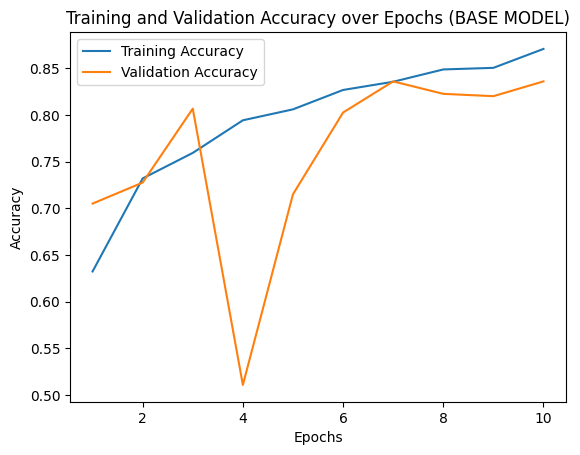

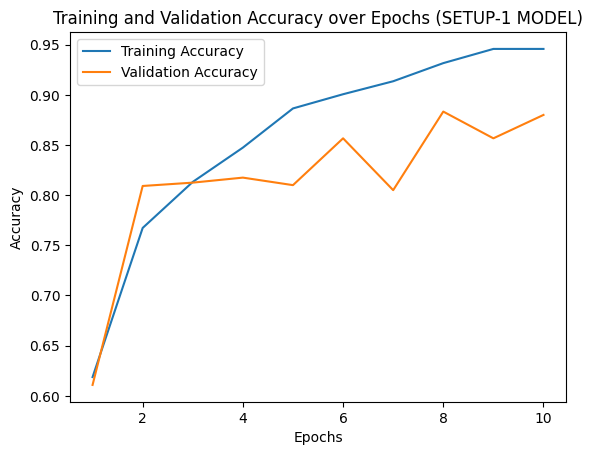

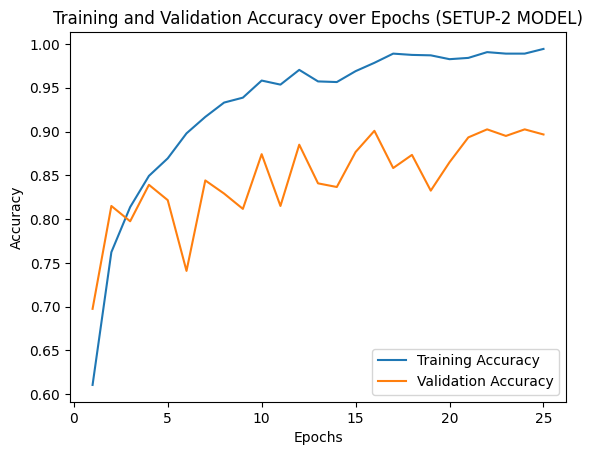

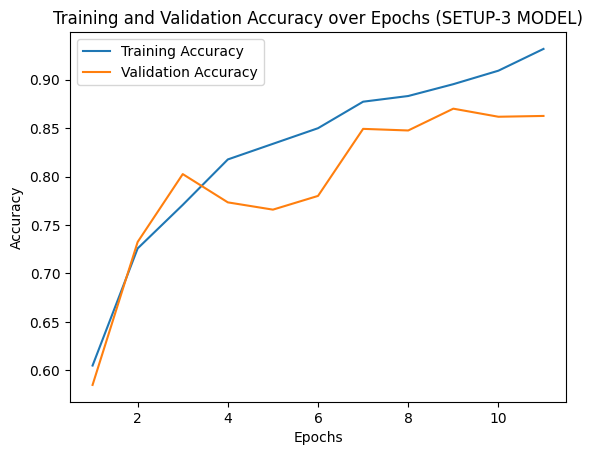

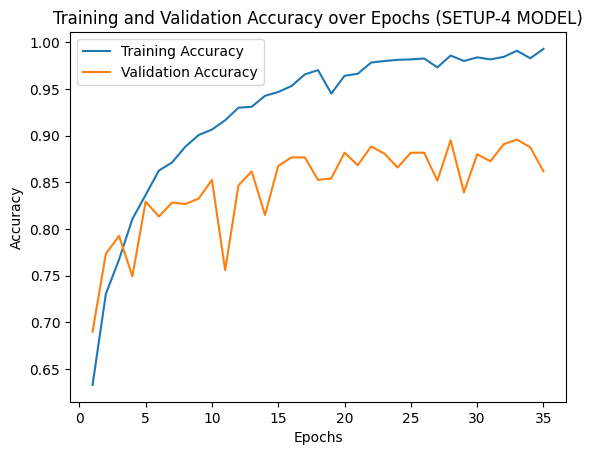

In [ ]:
'''
Plotting the training and validation accuracy over time (epochs).
'''

# BASE MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_base + 1), train_accuracies_base, label='Training Accuracy')
plt.plot(range(1, num_epochs_base + 1), valid_accuracies_base, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (BASE MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_1 + 1), train_accuracies_1, label='Training Accuracy')
plt.plot(range(1, num_epochs_1 + 1), valid_accuracies_1, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-1 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_2 + 1), train_accuracies_2, label='Training Accuracy')
plt.plot(range(1, num_epochs_2 + 1), valid_accuracies_2, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-2 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, last_num_epochs_3 + 1), train_accuracies_3[:last_num_epochs_3], label='Training Accuracy')
plt.plot(range(1, last_num_epochs_3 + 1), valid_accuracies_3[:last_num_epochs_3], label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-3 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Plotting training and validation accuracy
plt.plot(range(1, num_epochs_4 + 1), train_accuracies_4, label='Training Accuracy')
plt.plot(range(1, num_epochs_4 + 1), valid_accuracies_4, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (SETUP-4 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

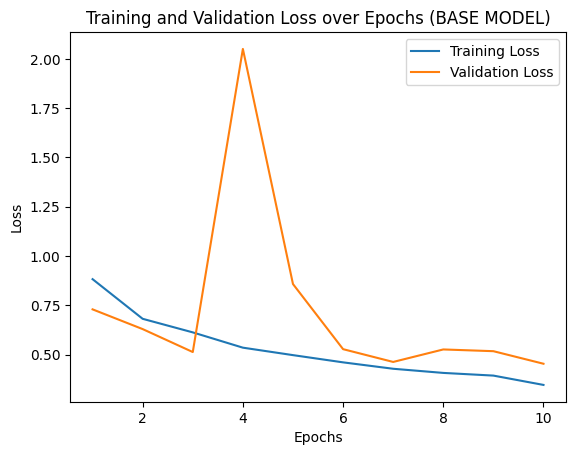

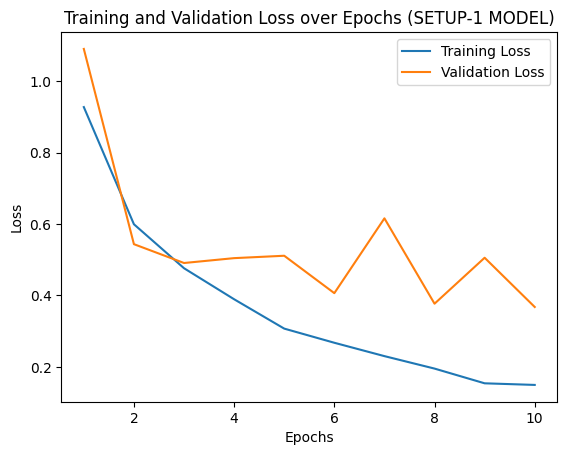

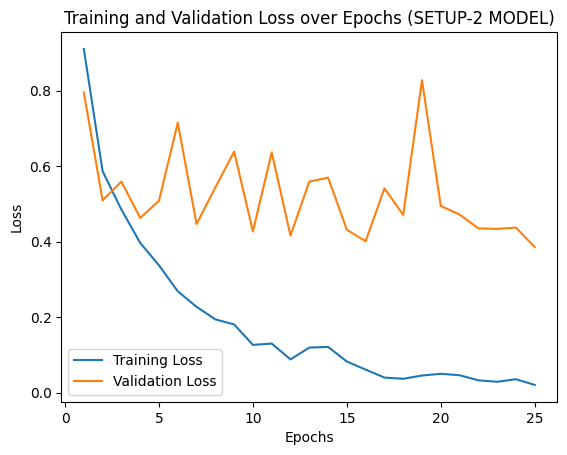

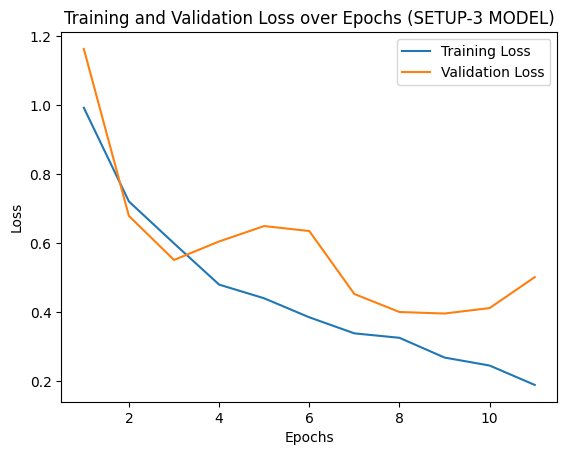

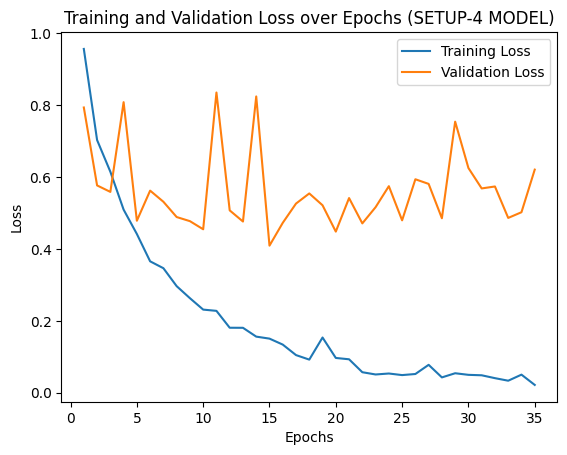

In [ ]:
'''
Plotting the training and validation loss over time (epochs).
'''

# BASE MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_base + 1), train_losses_base, label='Training Loss')
plt.plot(range(1, num_epochs_base + 1), valid_losses_base, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (BASE MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_1 + 1), train_losses_1, label='Training Loss')
plt.plot(range(1, num_epochs_base + 1), valid_losses_1, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-1 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_2 + 1), train_losses_2, label='Training Loss')
plt.plot(range(1, num_epochs_2 + 1), valid_losses_2, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-2 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, last_num_epochs_3 + 1), train_losses_3[:last_num_epochs_3], label='Training Loss')
plt.plot(range(1, last_num_epochs_3 + 1), valid_losses_3[:last_num_epochs_3], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-3 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Plot training and validation loss
plt.plot(range(1, num_epochs_4 + 1), train_losses_4, label='Training Loss')
plt.plot(range(1, num_epochs_4 + 1), valid_losses_4, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (SETUP-4 MODEL)')

# Adding legend
plt.legend()

# Showing plot
plt.show()

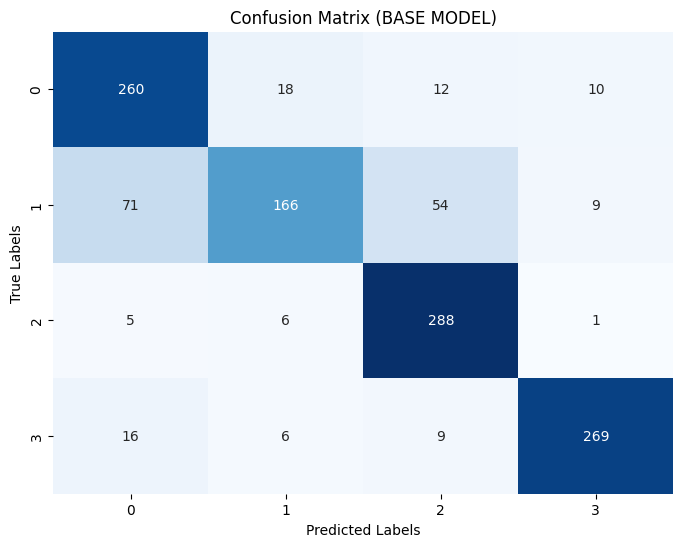

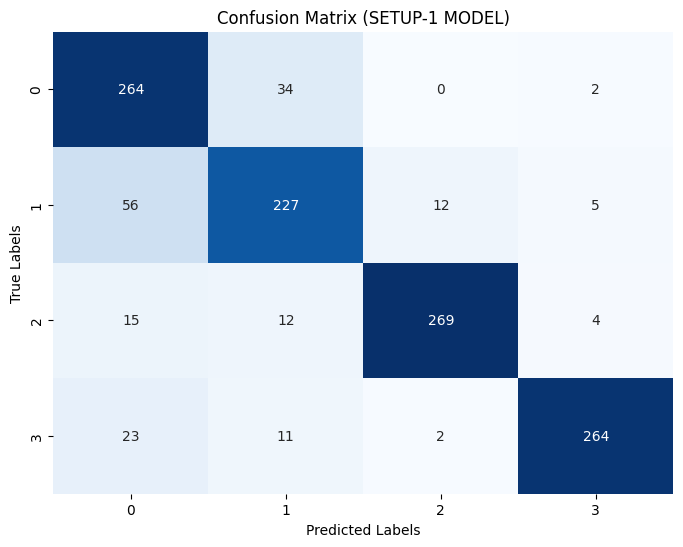

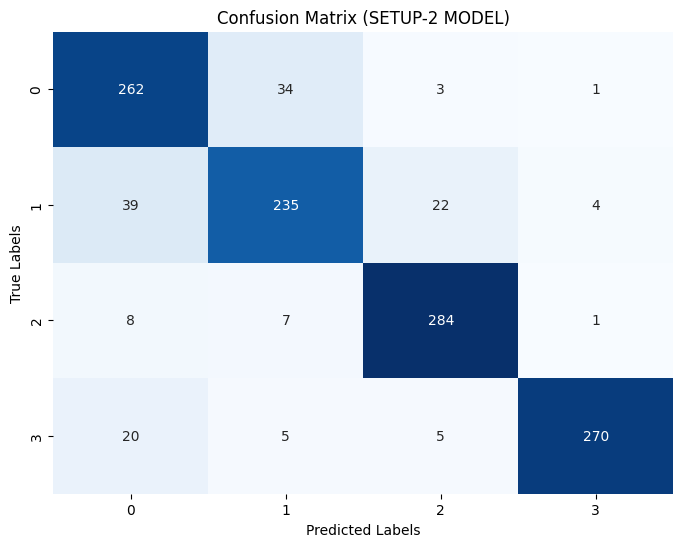

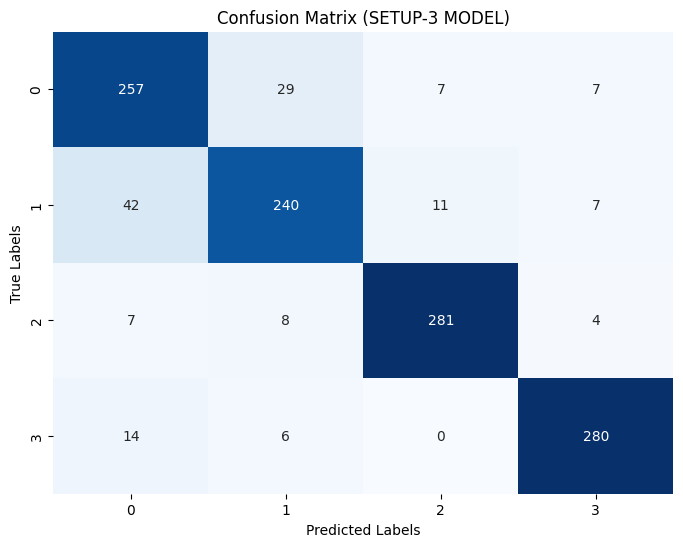

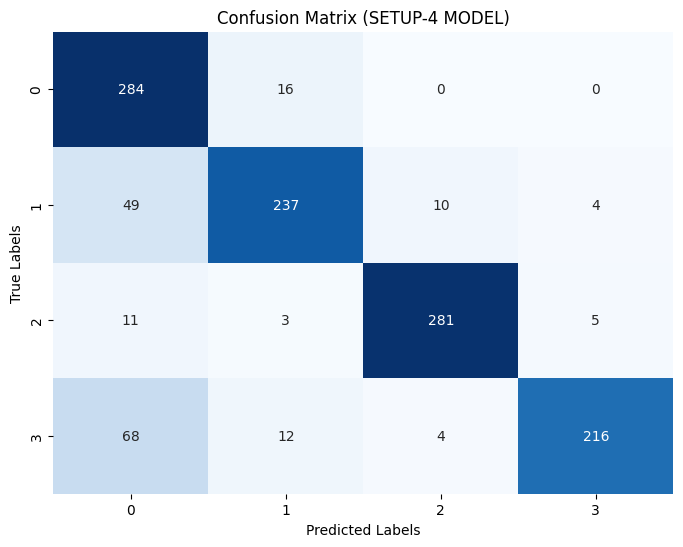

In [ ]:
'''
Generating a confusion matrix using the model's predictions on the test set.
'''

from sklearn.metrics import confusion_matrix

# BASE MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_base = np.array(testing_predictions_base)
true_labels_base = np.array(true_labels_base)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_base, testing_predictions_base)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BASE MODEL)')
plt.show()

print("\n")

# SETUP-1 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_1 = np.array(testing_predictions_1)
true_labels_1 = np.array(true_labels_1)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_1, testing_predictions_1)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-1 MODEL)')
plt.show()

print("\n")

# SETUP-2 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_2 = np.array(testing_predictions_2)
true_labels_2 = np.array(true_labels_2)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_2, testing_predictions_2)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-2 MODEL)')
plt.show()

print("\n")

# SETUP-3 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_3 = np.array(testing_predictions_3)
true_labels_3 = np.array(true_labels_3)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_3, testing_predictions_3)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-3 MODEL)')
plt.show()

print("\n")

# SETUP-4 MODEL 🔻

# Converting lists to numpy arrays
testing_predictions_4 = np.array(testing_predictions_4)
true_labels_4 = np.array(true_labels_4)

# Generating confusion matrix
conf_matrix = confusion_matrix(true_labels_4, testing_predictions_4)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SETUP-4 MODEL)')
plt.show()

In [ ]:
'''
Calculating and report other evaluation metrics such as Precision, recall and F1
score.
'''

from sklearn.metrics import precision_recall_fscore_support

# BASE MODEL 🔻

print("BASE MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_base, testing_predictions_base, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-1 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_1, testing_predictions_1, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-2 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_2, testing_predictions_2, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-3 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_3, testing_predictions_3, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

print("\n")

print("SETUP-4 MODEL 🔻")
# Calculating precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_4, testing_predictions_4, average='weighted')

# Report the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

BASE MODEL 🔻
Precision: 0.8274
Recall: 0.8192
F1-score: 0.8123


SETUP-1 MODEL 🔻
Precision: 0.8618
Recall: 0.8533
F1-score: 0.8552


SETUP-2 MODEL 🔻
Precision: 0.8788
Recall: 0.8758
F1-score: 0.8761


SETUP-3 MODEL 🔻
Precision: 0.8826
Recall: 0.8817
F1-score: 0.8818


SETUP-4 MODEL 🔻
Precision: 0.8715
Recall: 0.8483
F1-score: 0.8499
